In [9]:
import random
import gensim
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict


In [10]:
year='2018'
papers=pd.read_csv(f'/Users/pookansmacbookpro/Documents/CEDT Computer Engineering/Sem1_2024/2110403_DataSci/Project/ExtractedData/{year}.csv')

In [11]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

In [12]:
papers.head()

,Title,Abstract,Author,Aggregation_Type,Publisher,Publication_Date,Institutions,Keywords,Filename
0,Public health and international epidemiology f...,NaN,Pongpirul K.; Lungren M.P.,Book,Springer International Publishing,2018-12-31,Chulalongkorn University; Johns Hopkins Bloomb...,NaN,201800000
1,Flexible Printed Active Antenna for Digital Te...,"© 2018 The Institute of Electronics, Informati...",Pratumsiri T.; Janpugdee P.,Conference Proceeding,Institute of Electrical and Electronics Engine...,2018-12-31,Chulalongkorn University,NaN,201800001
2,Parametric study of hydrogen production via so...,© 2018 Elsevier LtdComputational fluid dynamic...,Phuakpunk K.; Chalermsinsuwan B.; Putivisutisa...,Journal,Elsevier Ltd,2018-12-31,Chulalongkorn University; Chulalongkorn Univer...,Circulating fluidized bed; Computational fluid...,201800002
3,Superhydrophobic coating from fluoroalkylsilan...,© 2018 Elsevier B.V. A superhydrophobic/supero...,Saengkaew J.; Le D.; Samart C.; Sawada H.; Nis...,Journal,Elsevier B.V.,2018-12-31,Thammasat University; Hirosaki University; Nat...,Encapsulation; Fluoroalkylsilane; Natural rubb...,201800003
4,Electrochemical impedance-based DNA sensor usi...,© 2018 Elsevier B.V. A label-free electrochemi...,Teengam P.; Siangproh W.; Tuantranont A.; Vila...,Journal,Elsevier B.V.,2018-12-31,Chulalongkorn University; Srinakharinwirot Uni...,acpcPNA; Electrochemical impedance spectroscop...,201800004


In [46]:
papers['Abstract'][4]

'© 2018 Elsevier B.V. A label-free electrochemical DNA sensor based on pyrrolidinyl peptide nucleic acid (acpcPNA)-immobilized on a paper-based analytical device (PAD) was developed. Unlike previous PNA-based electrochemical PAD (ePAD) sensors where the capture element was placed directly on the electrode, acpcPNA was covalently immobilized onto partially oxidized cellulose paper allowing regeneration by simple PAD replacement. As an example application, a sensor probe was designed for Mycobacterium tuberculosis (MTB) detection. The ePAD DNA sensor was used to determine a synthetic 15-base oligonucleotide of MTB by measuring the fractional change in the charge transfer resistance (R ct ) obtained from electrochemical impedance spectroscopy (EIS). The R ct of [Fe(CN) 6 ] 3-/4- before and after hybridization with the target DNA could be clearly distinguished. Cyclic voltammetry (CV) was used to verify the EIS results, and showed an increase in peak potential splitting in a similar stepwi

In [13]:
print(len(papers))

2792


In [14]:
texts = []
for i in range(len(papers)):
    title = str(papers['Title'][i]) if not pd.isna(papers['Title'][i]) else ''
    abstract = str(papers['Abstract'][i]) if not pd.isna(papers['Abstract'][i]) else ''
    text = title + ' ' + abstract
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

print(texts[1])

['flexible', 'printed', 'active', 'antenna', 'for', 'digital', 'television', 'reception', '2018', 'the', 'institute', 'of', 'electronics', 'information', 'and', 'communication', 'engineers', 'ieice', 'this', 'paper', 'presents', 'the', 'development', 'of', 'a', 'flexible', 'printed', 'active', 'antenna', 'for', 'the', 'digital', 'television', 'dtv', 'reception', 'in', 'areas', 'having', 'poor', 'signal', 'or', 'in', 'high', 'rise', 'buildings', 'the', 'antenna', 'structure', 'is', 'composed', 'of', 'a', 'meander', 'line', 'printed', 'on', 'a', 'polyimide', 'film', 'as', 'a', 'radiating', 'element', 'it', 'has', 'a', 'thickness', 'of', '0', '3', 'mm', 'highly', 'flexible', 'and', 'very', 'lightweight', 'the', 'design', 'and', 'analysis', 'of', 'the', 'radiating', 'element', 'are', 'based', 'on', 'a', 'full', 'wave', 'method', 'implemented', 'by', 'a', 'commercial', 'electromagnetic', 'simulation', 'software', 'the', 'amplifier', 'circuit', 'consisting', 'of', 'a', 'surface', 'mount', 't

In [15]:
import logging
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 152 stopwords
loaded 42 bigrams
loaded 2 stem rules


In [16]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))

Top words


,word,count,in stopwords.txt?
0,the,32418,Yes
1,of,24084,Yes
2,and,21911,Yes
3,in,14126,Yes
4,to,11071,Yes
5,a,9076,
6,with,6549,Yes
7,for,6135,Yes
8,were,4881,Yes
9,was,4819,Yes


In [17]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(p, 0)",712,
1,"(rights, reserved)",446,
2,"(95, ci)",340,
3,"(author, s)",288,
4,"(2018, elsevier)",267,
5,"(0, 001)",205,
6,"(0, 05)",205,
7,"(b, v)",193,
8,"(proton, proton)",192,
9,"(elsevier, b)",166,


In [18]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [19]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [20]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

,Original,Stem,Unstem,Count
0,study,studi,study,2143
1,patients,patient,patients,1441
2,thailand,thailand,thailand,1083
3,data,data,data,1068
4,analysis,analysi,analysis,1066
5,group,group,group,824
6,model,model,model,806
7,methods,method,methods,708
8,found,found,found,697
9,respectively,respect,respectively,695


In [22]:
# Remove papers with less than 25 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 25]
papers = papers.iloc[indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 2683 (removed 109)


In [23]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

papers: 2683
dictionary size: 4868


In [24]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq

In [26]:
num_topics = 12
seed = 7

tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

violation: 1.0
violation: 0.21098441757543465
violation: 0.13899533150762075
violation: 0.10135331227386168
violation: 0.07746324194243345
violation: 0.06146474911616819
violation: 0.05051390895892808
violation: 0.04207385614858462
violation: 0.0350507432656624
violation: 0.030037336045929872
violation: 0.026755339998917847
violation: 0.02452608279436623
violation: 0.02225955874626035
violation: 0.02000469621231407
violation: 0.01764637590038861
violation: 0.015584763871907175
violation: 0.013781015265212514
violation: 0.012189035670956116
violation: 0.010804530866485227
violation: 0.009621857249205659
violation: 0.008624753344223409
violation: 0.007781047497306387
violation: 0.007042889316601621
violation: 0.006383681565038572
violation: 0.0057802711444953055
violation: 0.005273586012458662
violation: 0.004841640144378291
violation: 0.004491427300369199
violation: 0.004202840204835551
violation: 0.003964423990428023
violation: 0.0037713187160652263
violation: 0.0036244839273207818
vio

In [27]:
rows = []
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,model (0.01),system (0.0071),data (0.0061),algorithm (0.006),network (0.0056),technique (0.0054),performance (0.0046),estimation (0.004),process (0.0039),computed (0.0038)
1,B,proton (0.033),decay (0.03),boson (0.028),mass (0.026),search (0.025),quark (0.024),tev (0.022),higgs (0.017),pair (0.017),production (0.016)
2,C,oil (0.013),co2 (0.013),production (0.012),water (0.011),process (0.0099),gas (0.0084),carbon (0.0082),temperature (0.0069),waste (0.006),extract (0.0056)
3,D,cells (0.042),cancer (0.02),activity (0.012),compounds (0.0096),expression (0.0089),protein (0.0085),cytotoxicity (0.0077),induced (0.0077),lung (0.0076),line (0.0065)
4,E,patients (0.026),group (0.0097),treatment (0.0071),risk (0.0063),outcomes (0.0062),ci (0.006),disease (0.0058),clinical (0.0055),years (0.005),after (0.0047)
5,F,species (0.05),sp (0.021),genus (0.016),thailand (0.016),nov (0.013),morphology (0.0097),described (0.0087),dna (0.0087),illustrate (0.007),descriptive (0.0054)
6,G,health (0.011),students (0.0091),education (0.0086),thailand (0.0082),factors (0.0068),knowledge (0.0065),learning (0.0063),thai (0.0056),research (0.0055),practice (0.0054)
7,H,film (0.01),properties (0.008),composite (0.0075),surface (0.0062),pla (0.0058),graphene (0.0054),structure (0.0054),prepared (0.0045),poly (0.0045),strength (0.0042)
8,I,gene (0.016),isolated (0.015),infection (0.012),strain (0.01),resistance (0.0094),protein (0.0085),shrimp (0.0081),sequence (0.008),detection (0.0069),expression (0.0065)
9,J,catalyst (0.05),tio2 (0.02),activity (0.015),catalytic (0.013),hydrogen (0.013),acid (0.012),pd (0.012),carbon (0.011),reaction (0.01),h2 (0.01)


Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


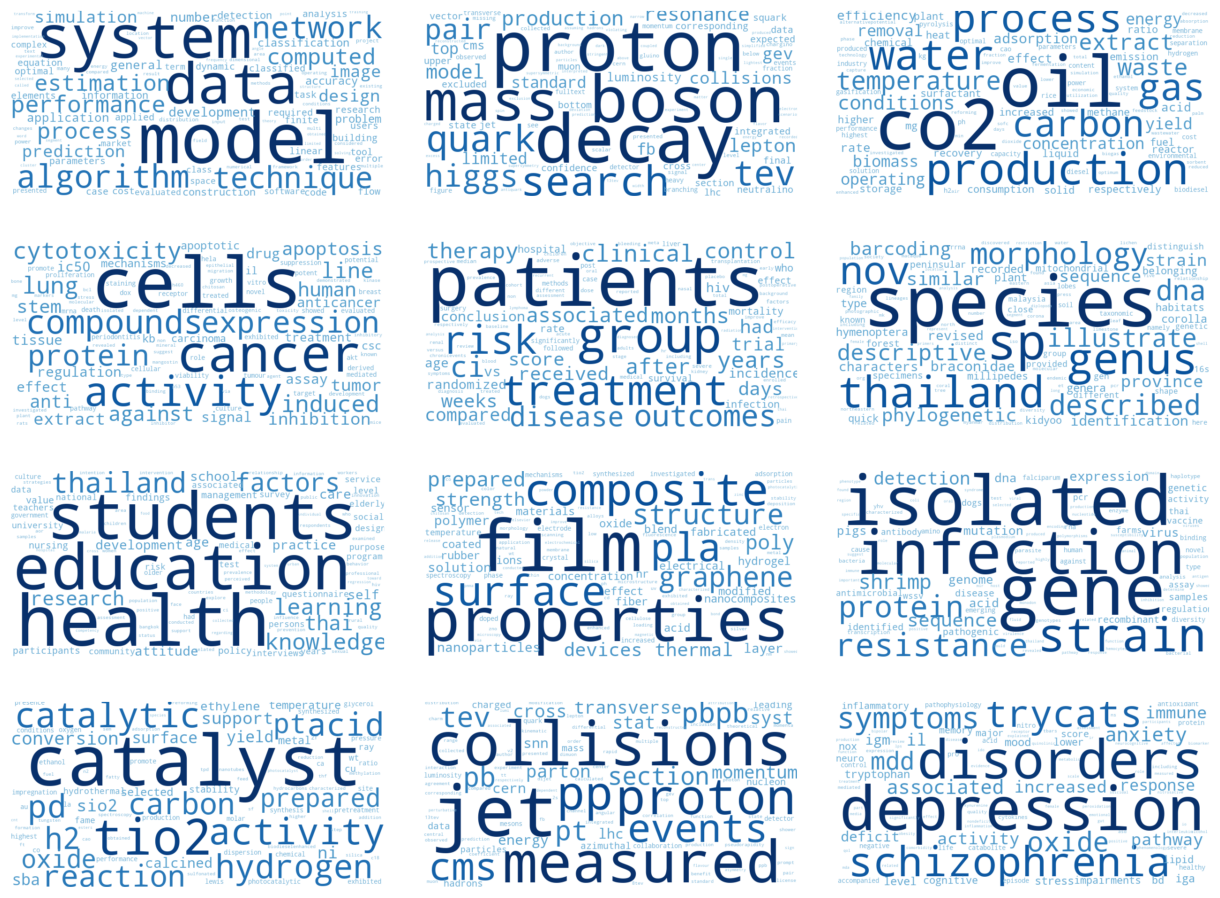

In [28]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2683 samples in 0.001s...
[t-SNE] Computed neighbors for 2683 samples in 0.238s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2683
[t-SNE] Computed conditional probabilities for sample 2000 / 2683
[t-SNE] Computed conditional probabilities for sample 2683 / 2683
[t-SNE] Mean sigma: 0.010278
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.275383
[t-SNE] KL divergence after 1000 iterations: 1.215418


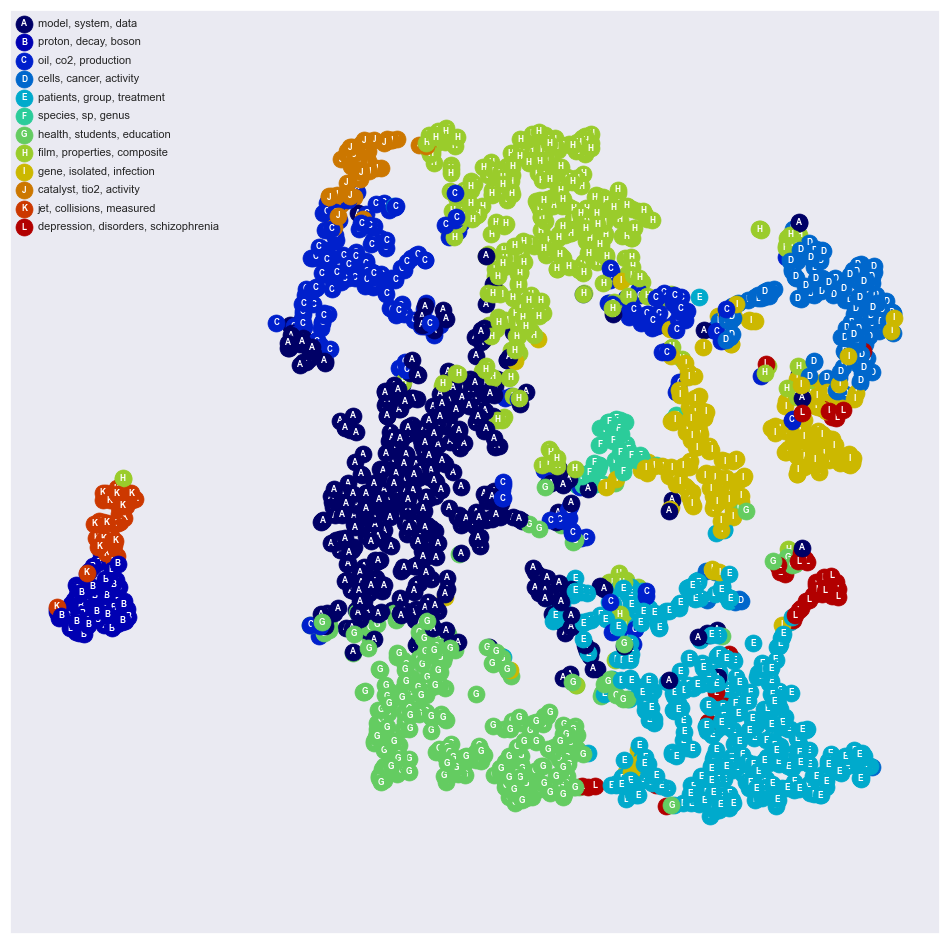

In [30]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD
vis_seed = 6
vis_angle = 135

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

In [43]:
def on_select(i):
    i=i-1
    p = papers.iloc[i]
    print(p['Title'])
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    fig = prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p['Abstract'])

options = sorted([((p['Title'] or '').strip()[:50], i) for i, p in papers.iterrows()])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
display(widget)

interactive(children=(Dropdown(description='i', options=(('16S metagenomic analysis reveals adaptability of a'…